In [ ]:
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import rc
from matplotlib import animation
from matplotlib.colors import ListedColormap

matplotlib.rcParams['figure.dpi'] = 360
matplotlib.rcParams['text.usetex'] = True
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']
# plt.style.use('dark_background')
rc('animation', html = 'jshtml')
matplotlib.rcParams['animation.embed_limit'] = 2**128

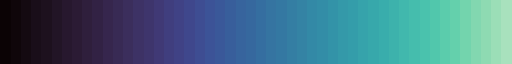

In [66]:
cmap = sns.color_palette('mako', as_cmap=True)
col = cmap(np.linspace(0.0, 0.9, ))
cmap = ListedColormap(col)
cmap

### Using Runge-Kutta 4th

#### 2D Scattering

In [ ]:
def acceleration(x, y, C):
    """
    Calcula la aceleración debida a la fuerza de Coulomb en una partícula.

    La aceleración se obtiene a partir de:
        aₓ = C * x / r³   y   aᵧ = C * y / r³
    con r = sqrt(x² + y²) y C como la constante que agrupa k, q₁, q₂ y m.

    Parameters:
        x (float): Posición en x.
        y (float): Posición en y.
        C (float): Constante de interacción = k*q1*q2/m.

    Returns:
        (a_x, a_y): Tuple con las aceleraciones en x e y.
    """
    r = np.sqrt(x**2 + y**2)
    if r == 0: # math error prevention
        print("Division by zero in acceleration function.")
        return 0.0, 0.0
    a_x = C * x / r**3
    a_y = C * y / r**3
    return a_x, a_y

In [23]:
def derivatives(state, C):
    """
    Calcula las derivadas del vector de estado para las ecuaciones diferenciales.

    El vector de estado se define como:
        state = [x, y, vx, vy]
    y las derivadas son:
        dx/dt = vx
        dy/dt = vy
        dvx/dt = aₓ = C*x / r³
        dvy/dt = aᵧ = C*y / r³

    Parameters:
        state (ndarray): Vector de estado actual.
        C (float): Constante de interacción.

    Returns:
        dstate (ndarray): Derivadas del vector de estado.
    """
    x, y, vx, vy = state
    a_x, a_y = acceleration(x, y, C)
    return np.array([vx, vy, a_x, a_y])

In [ ]:
def rk4_step(state, dt, C):
    """
    Realiza un paso de integración usando el método Runge-Kutta de cuarto orden.

    La actualización se realiza usando la siguiente fórmula:
        S(t+Δt) = S(t) + (Δt/6)*(k1 + 2*k2 + 2*k3 + k4)     -> (Fórmula de RK4)
    donde:
        k1 = f(S(t))
        k2 = f(S(t) + (Δt/2)*k1)
        k3 = f(S(t) + (Δt/2)*k2)
        k4 = f(S(t) + Δt*k3) -> (4to orden)

    Parameters:
        state (ndarray): Vector de estado [x, y, vx, vy] en el tiempo t.
        dt (float): Paso de tiempo para la integración.
        C (float): Constante de interacción.

    Returns:
        new_state (ndarray): Vector actualizado del estado en t+Δt.
    """
    k1 = derivatives(state, C)
    k2 = derivatives(state + 0.5 * dt * k1, C)
    k3 = derivatives(state + 0.5 * dt * k2, C)
    k4 = derivatives(state + dt * k3, C)
    new_state = state + dt * (k1 + 2*k2 + 2*k3 + k4) / 6.0
    return new_state

In [ ]:
def simulate_trajectory(b, x0, v0, dt, t_final, C):
    """
    Simula la trayectoria de una partícula usando RK4.

    La partícula parte de la posición inicial (x0, b) con velocidad inicial (v0, 0):
        x = x0  (posición inicial en x, debe ser un valor grande debido a la lejanía del núcleo)
        y = b   (parámetro de impacto, representa la posición en y)
        vx = v0 (velocidad inicial en x)
        vy = 0  (velocidad inicial en y)

    Parameters:
        b (float): Parámetro de impacto, valor inicial en y.
        x0 (float): Posición inicial en x.
        v0 (float): Velocidad inicial en x.
        dt (float): Paso de tiempo para la integración.
        t_final (float): Tiempo total de simulación.
        C (float): Constante de interacción.

    Returns:
        traj (ndarray): Matriz de trayectoria de forma (n_steps, 4) con columnas [x, y, vx, vy].
    """
    n_steps = int(t_final / dt) + 1
    traj = np.empty((n_steps, 4))
    state = np.array([x0, b, v0, 0.0])
    traj[0] = state
    for i in range(1, n_steps):
        state = rk4_step(state, dt, C)
        traj[i] = state
    return traj

In [163]:
def plot_scatter(b_values):
    C = 1.0  # Usamos C = k*q1*q2/m como un valor adimensional para simplificar la simulación
    x0, v0 = -10.0, 1.0
    dt, t_final = 0.001, 20.0

    cmap = sns.color_palette('mako', as_cmap=True)
    col = cmap(np.linspace(0.0, 0.9, len(b_values)))

    trajectories = {}
    for b in b_values:
        traj = simulate_trajectory(b, x0, v0, dt, t_final, C)
        trajectories[b] = traj

    if len(b_values) < 15:
        ax = plt.figure().add_subplot(111)
        for i, (b, traj) in enumerate(trajectories.items()):
            ax.plot(traj[:, 0], traj[:, 1], c=col[i], label=f'$b$ = ${b:.2f}$')

        ax.set_xlabel('$x$'); ax.set_ylabel('$y$')
        ax.set_title('Dispersión de Rutherford usando RK4', y=1.02)
        ax.legend(); ax.grid(True, linewidth=0.2)
        plt.show()

    return trajectories

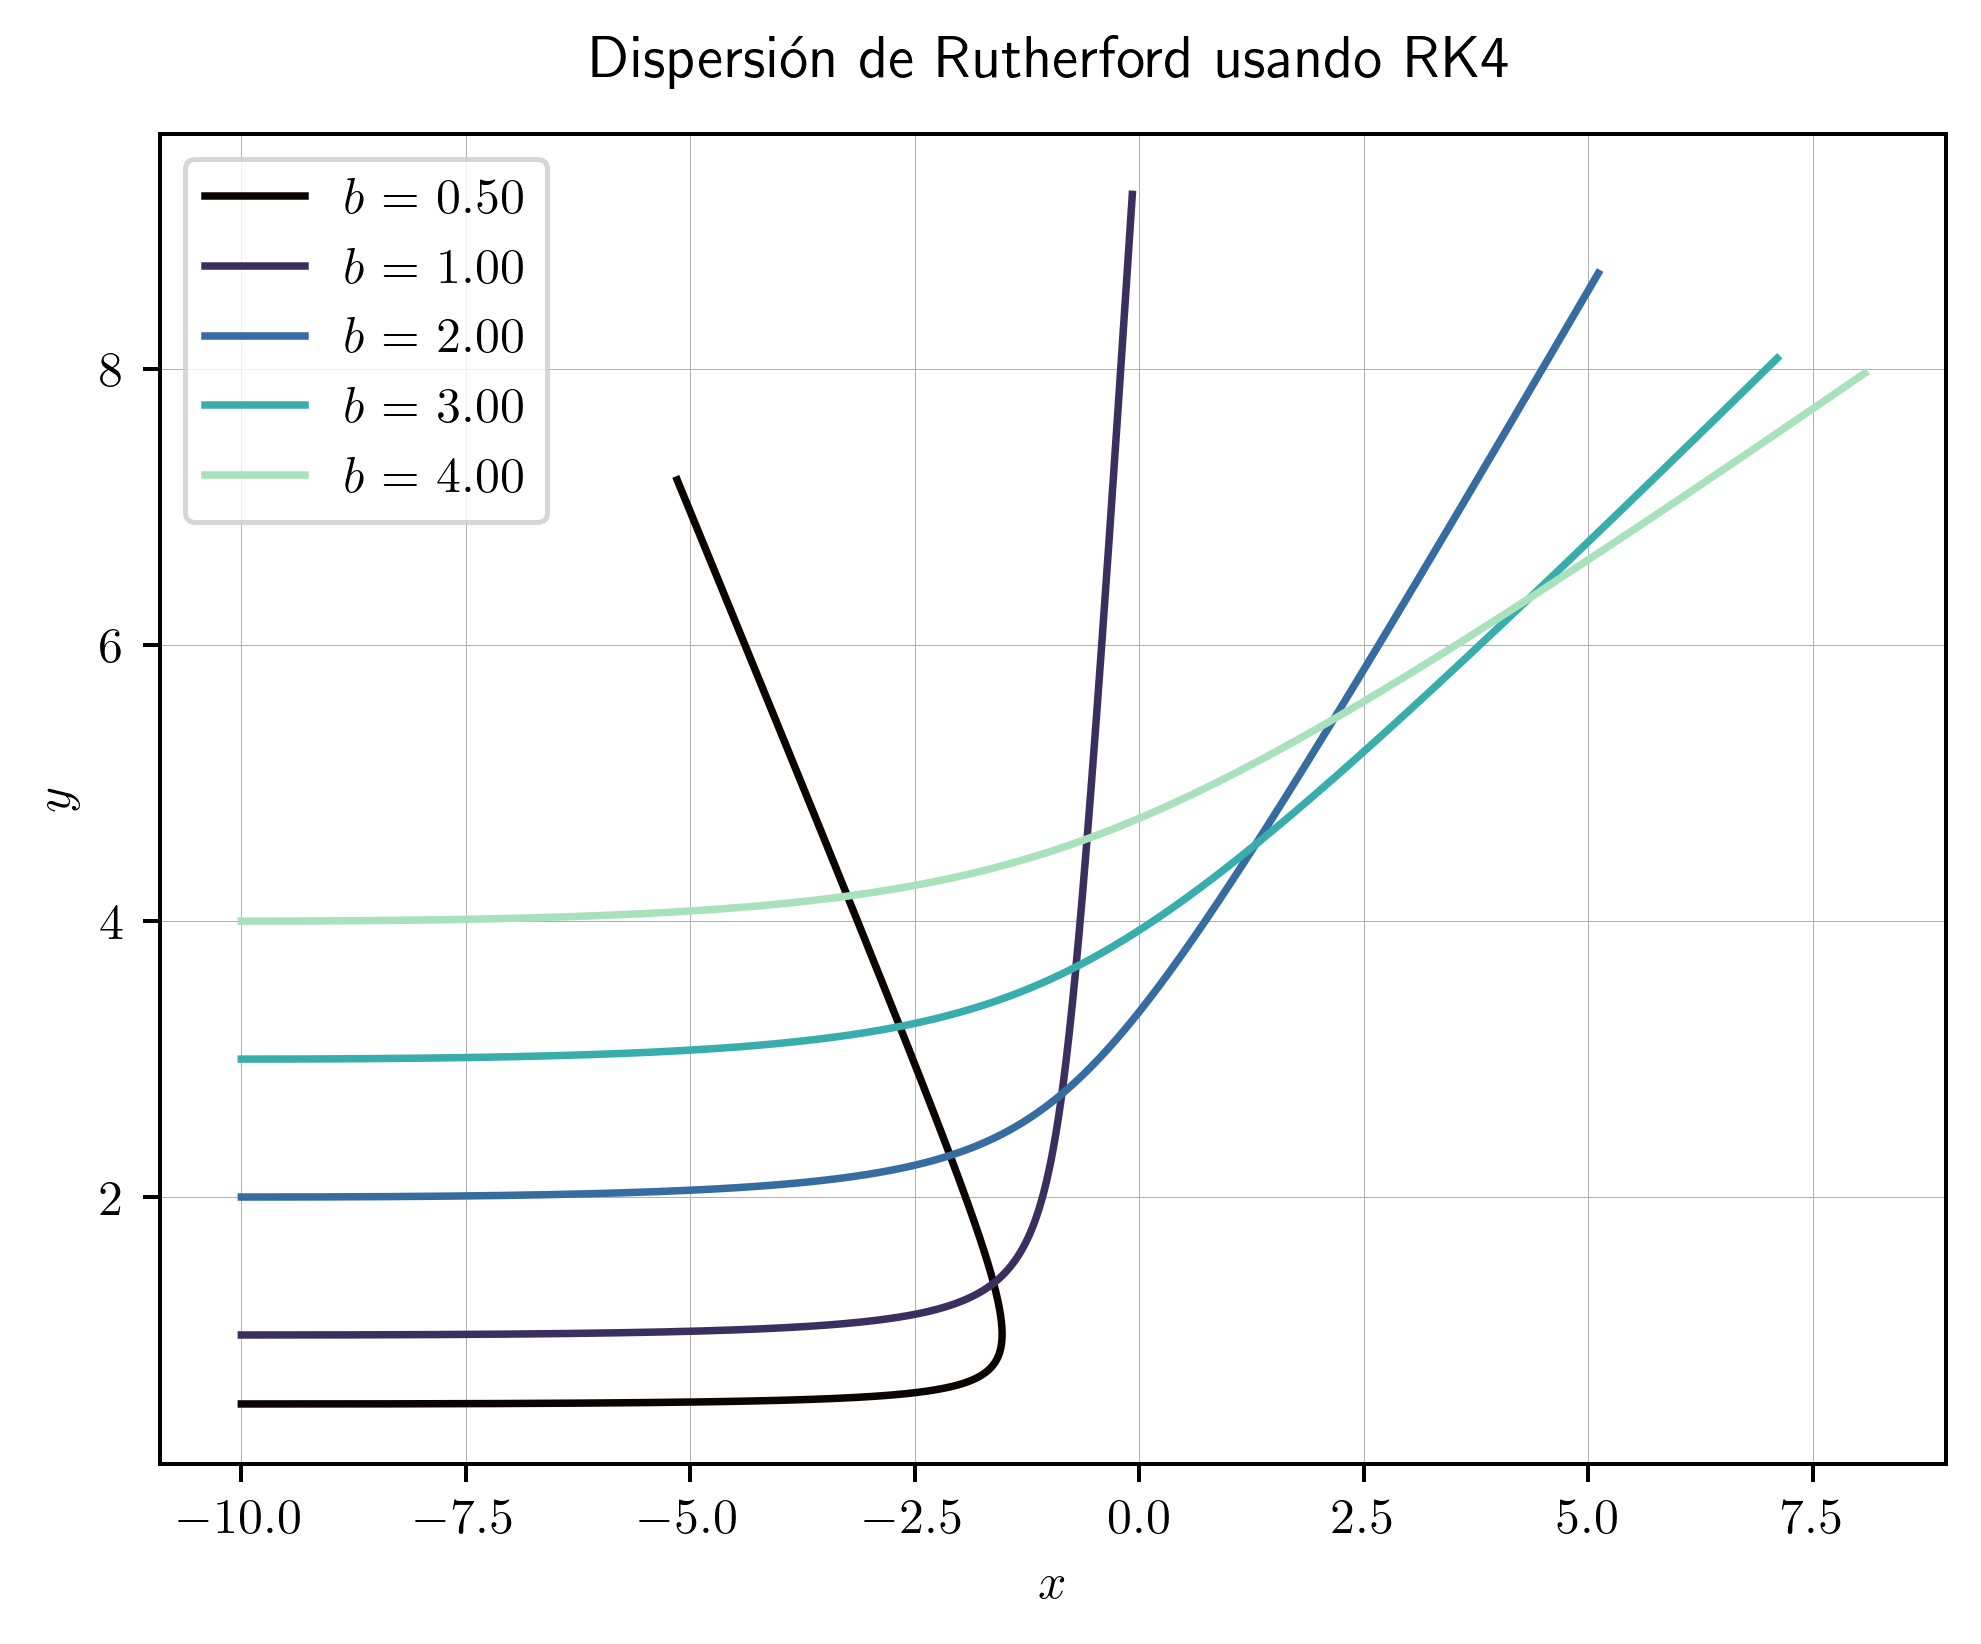

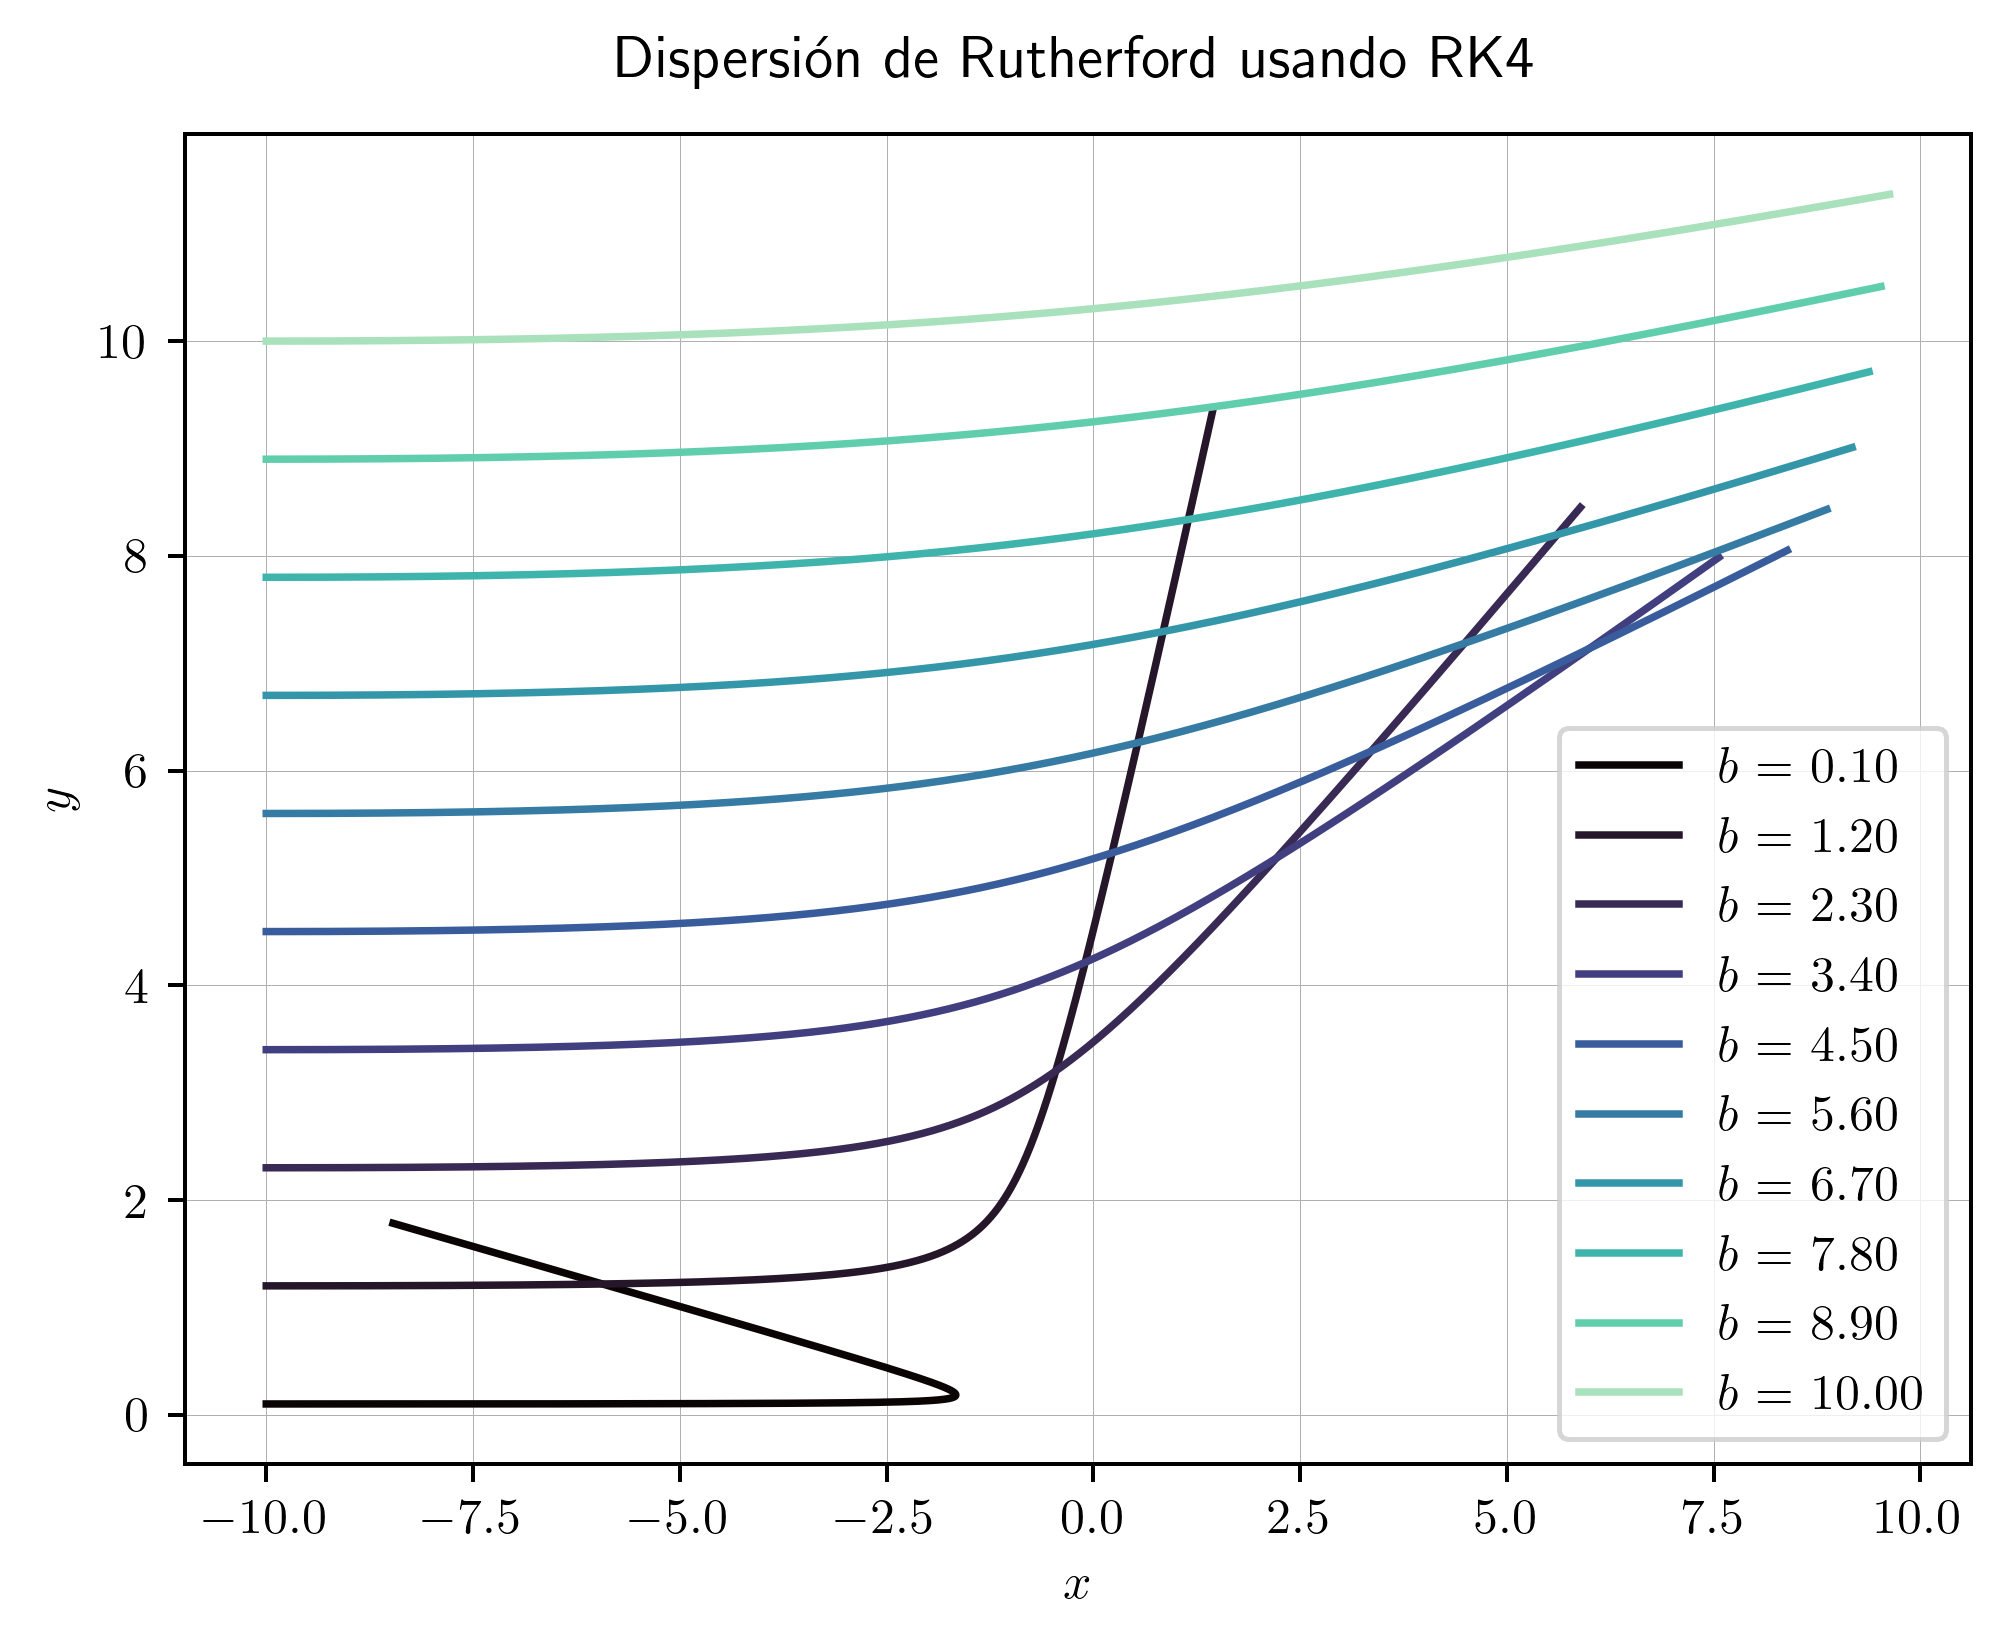

In [164]:
trajectories_v1 = plot_scatter([0.5, 1.0, 2.0, 3.0, 4.0])
trajectories_v2 = plot_scatter(np.linspace(0.1, 10, 10))
trajectories_v3 = plot_scatter(np.linspace(0.1, 10, 100))

#### Relación entre $b$ y $\theta$

In [ ]:
def plot_angles(trajectories, col):
    b_list, theta_list = [], []
    for b, traj in trajectories.items():
        final_vx, final_vy = traj[-1, 2], traj[-1, 3] # Última posición y velocidad

        angle_rad = np.arctan2(final_vy, final_vx) # Ángulo con respecto al eje X
        angle_deg = np.degrees(angle_rad) # Convertir a grados

        b_list.append(b); theta_list.append(angle_deg)

    sorted_data = sorted(zip(b_list, theta_list), key=lambda x: x[0])
    b_sorted, theta_sorted = zip(*sorted_data)

    if len(trajectories) > 15:
        _, ax = plt.subplots()
        ax.plot(b_sorted, theta_sorted, marker='.', c=col)
        ax.set_xlabel('$b$'); ax.set_ylabel('$\\theta$ $[deg]$')
        ax.set_title('Relación entre $b$ y ángulo de dispersión $\\theta$', y=1.02)
        ax.grid(True, linewidth=0.2)
        plt.show()

    return b_sorted, theta_sorted

In [113]:
b, theta = plot_angles(trajectories_v1, col[5])
for b, theta in zip(b, theta):
    print(f'b = {b:.2f}, θ = {theta:.2f}°')

b = 0.50, θ = 122.28°
b = 1.00, θ = 84.24°
b = 2.00, θ = 48.11°
b = 3.00, θ = 32.54°
b = 4.00, θ = 24.09°


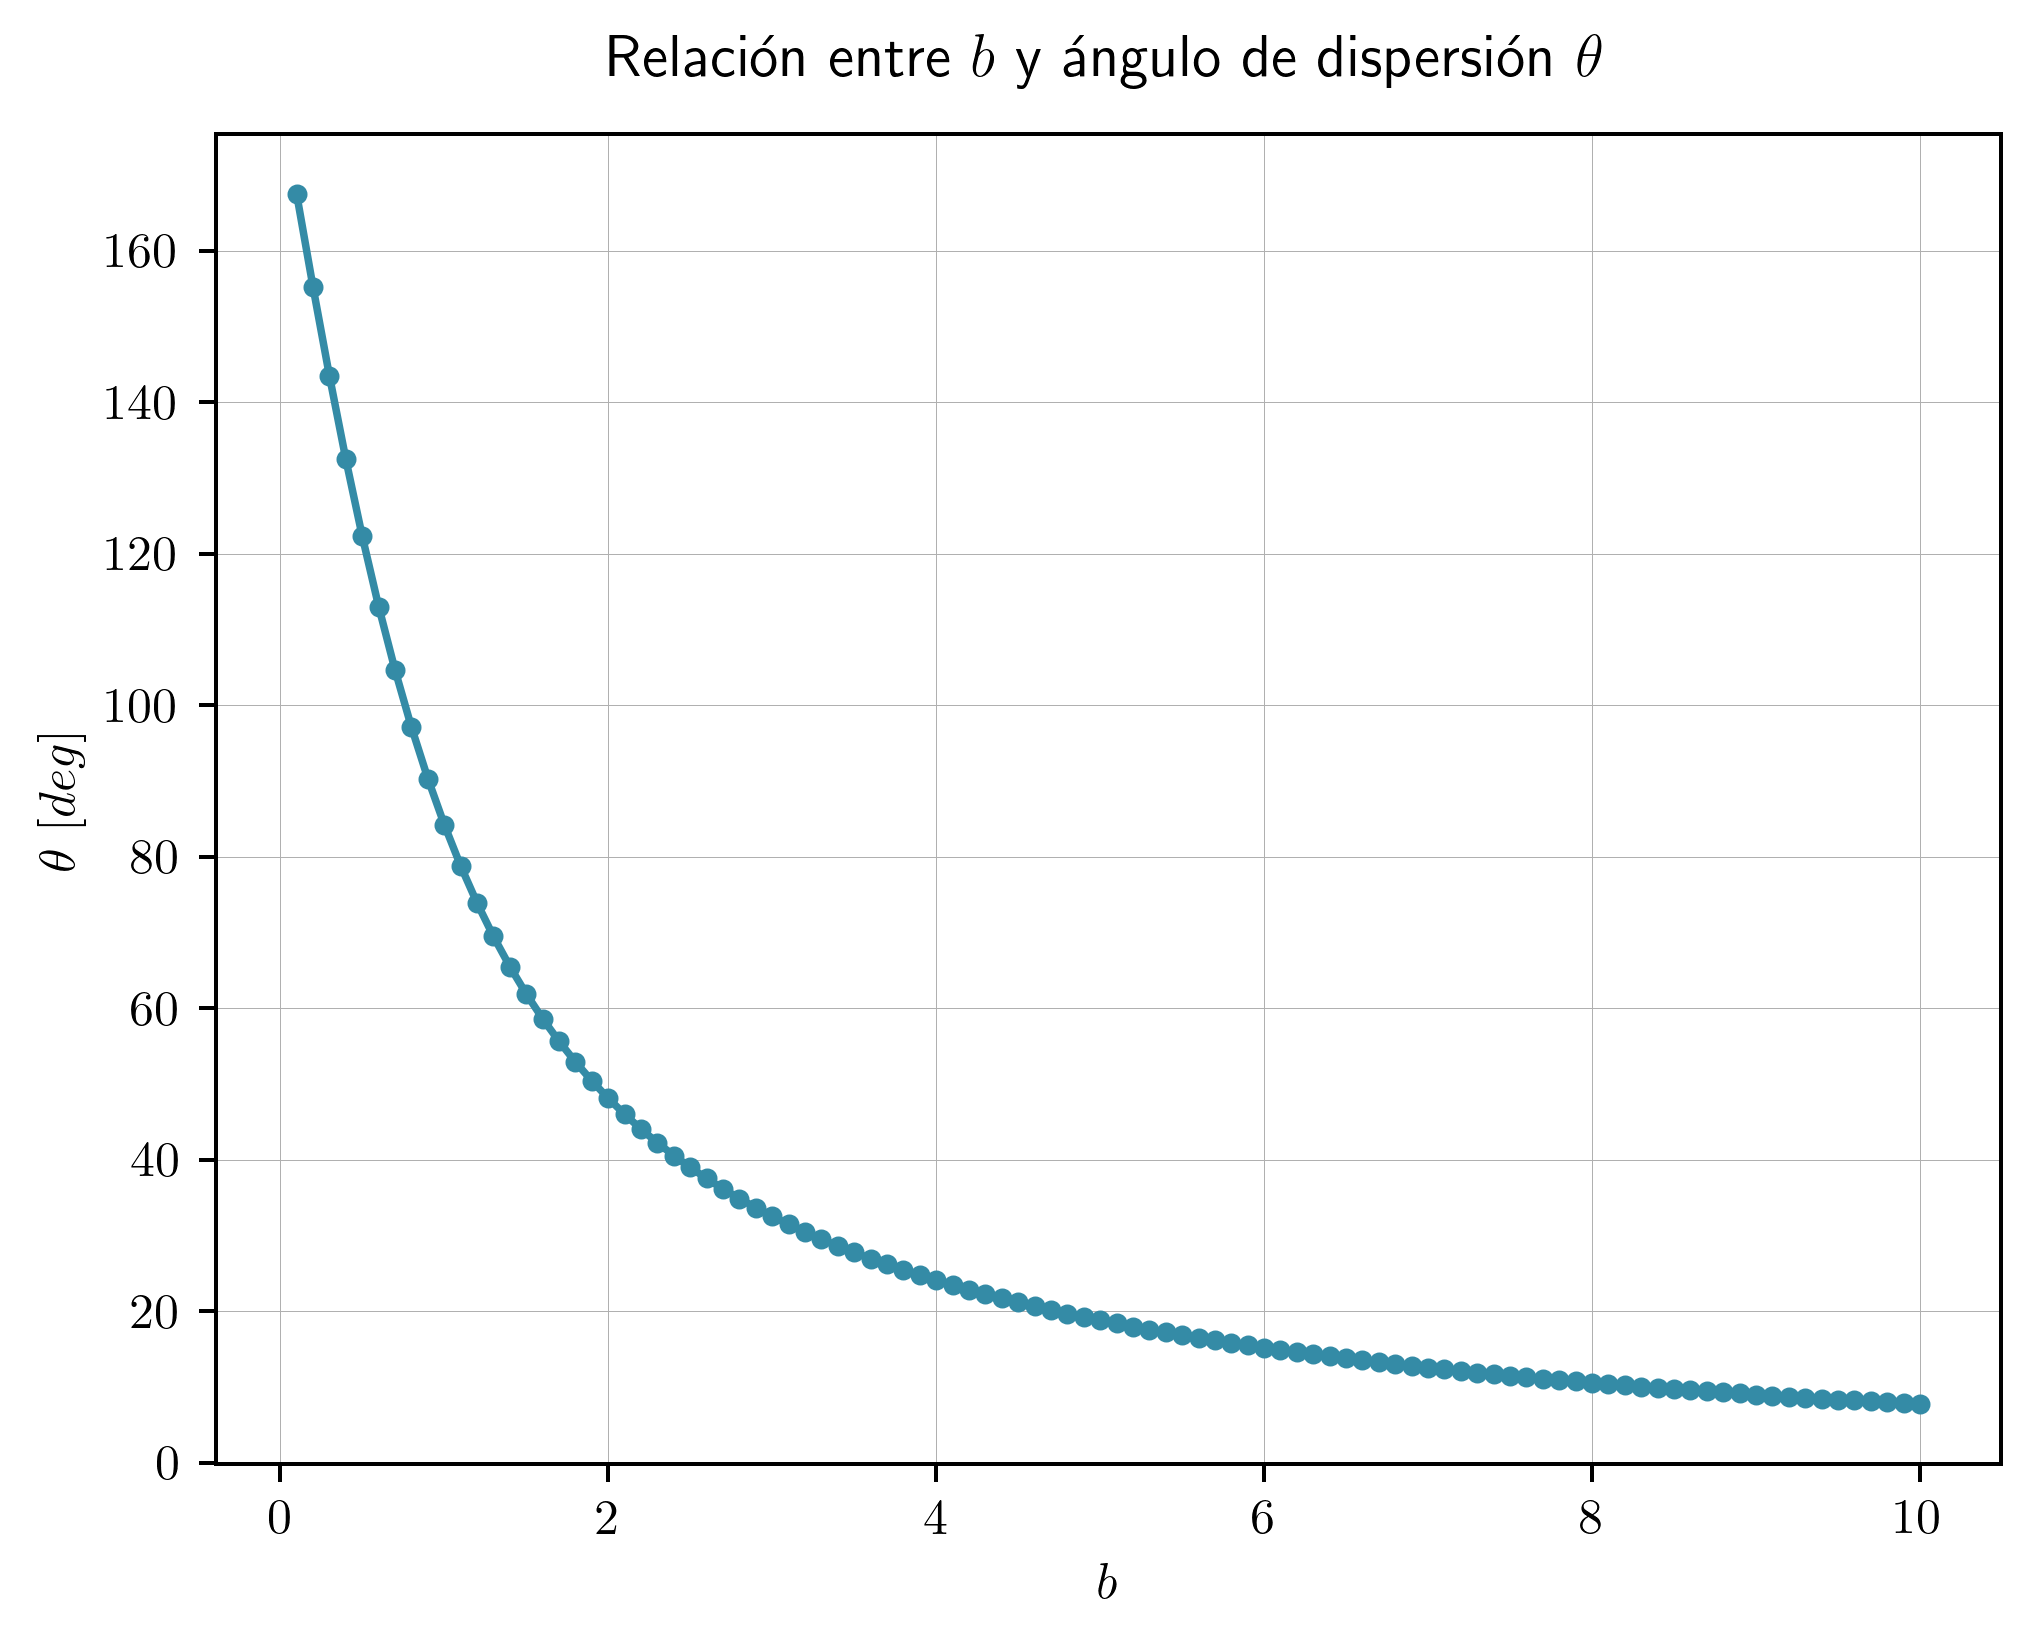

In [114]:
cmap = sns.color_palette('mako', as_cmap=True)
col = cmap(np.linspace(0.0, 1.0, 10))

_, _ = plot_angles(trajectories_v3, col[5])

#### Distancia $r$ hasta el núcleo atómico

In [166]:
def plot_min_distances(trajectories):
    cmap = sns.color_palette('mako', as_cmap=True)
    col = cmap(np.linspace(0.0, 0.9, len(trajectories)))
    min_distances = {}

    _, ax = plt.subplots()
    for i, (b, traj) in enumerate(trajectories.items()):
        x_vals, y_vals = traj[:, 0], traj[:, 1]
        r_vals = np.sqrt(x_vals**2 + y_vals**2)  # distancia al núcleo (0,0)

        r_min = np.min(r_vals)
        min_distances[b] = r_min

        ax.plot(r_vals, c=col[i], label=f'$b$ = ${b:.2f}$')

    ax.set_xlabel('$i$'); ax.set_ylabel('$r$')
    ax.set_title('Distancia al núcleo', y=1.02)
    ax.grid(True, linewidth=0.2)
    plt.subplots_adjust(top=0.85)
    ax.legend(loc='center right', bbox_to_anchor=(1.27, 0.5), ncol=1)
    if len(trajectories) > 5:
        plt.show()

    return min_distances

  b = 0.50: r_min = 1.7838
  b = 1.00: r_min = 2.0708
  b = 2.00: r_min = 2.8468
  b = 3.00: r_min = 3.7128
  b = 4.00: r_min = 4.6124


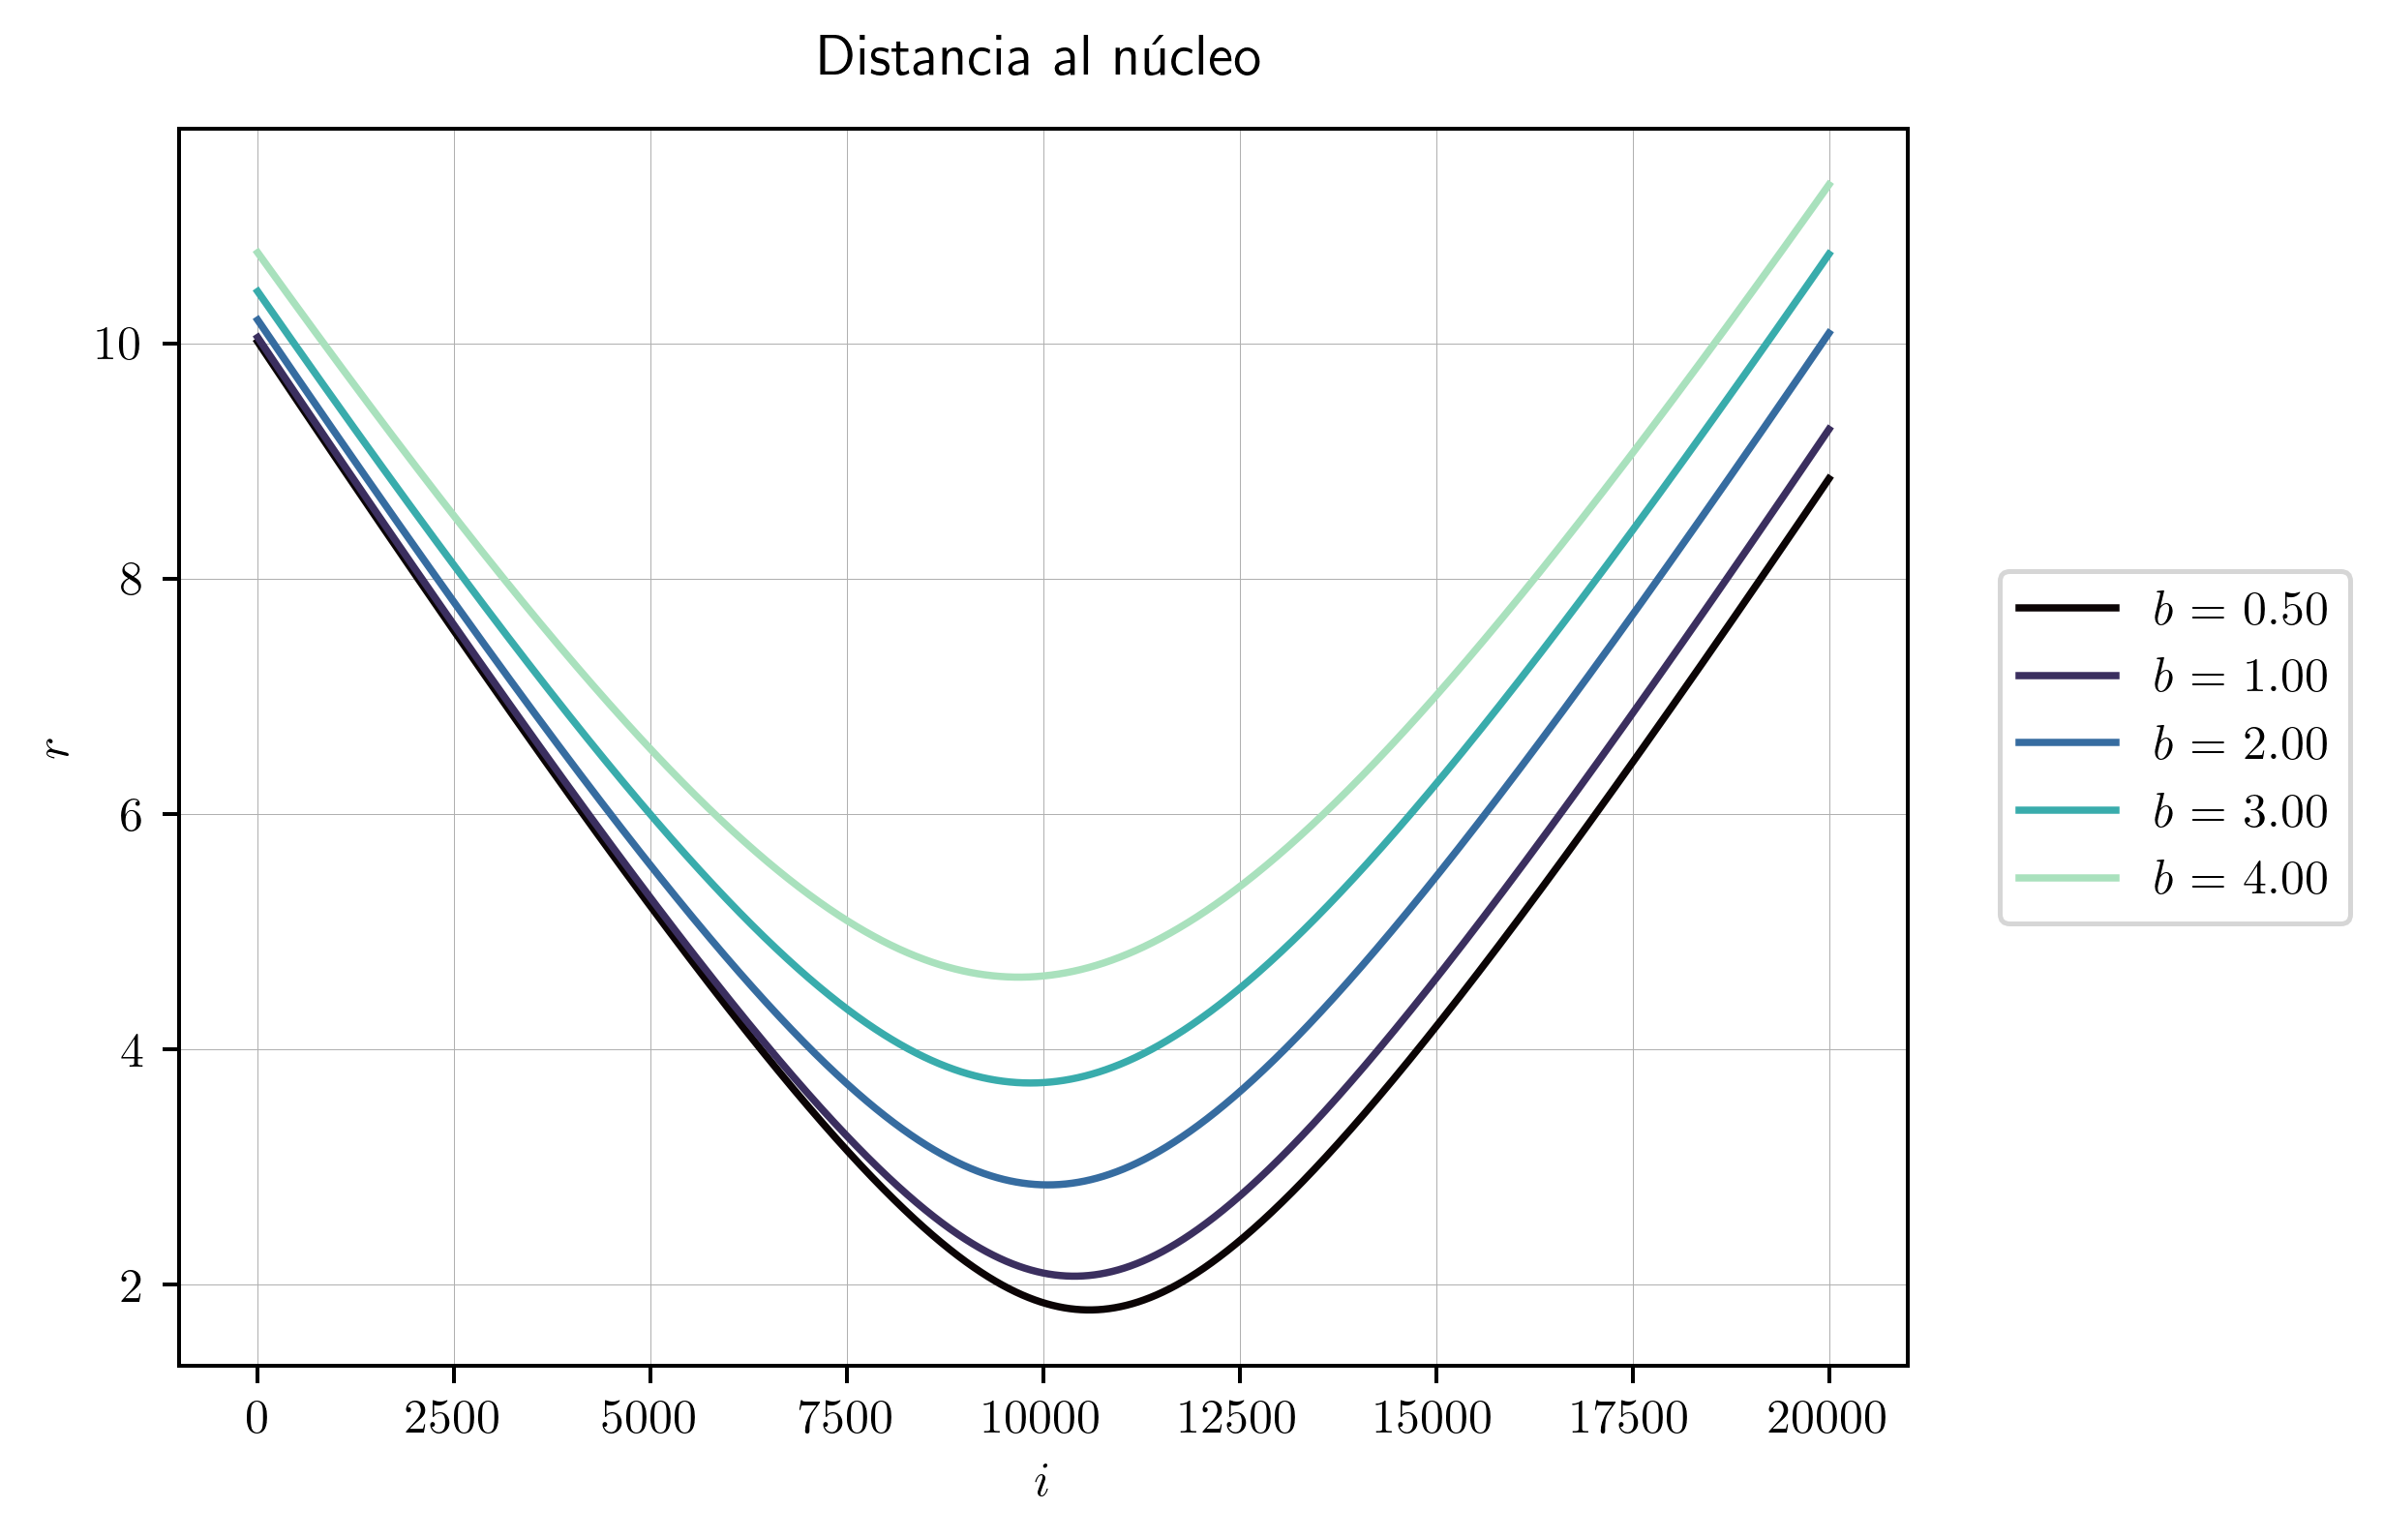

In [170]:
min_distances = plot_min_distances(trajectories_v1)
for b, r_min in min_distances.items():
    print(f"  b = {b:.2f}: r_min = {r_min:.4f}")

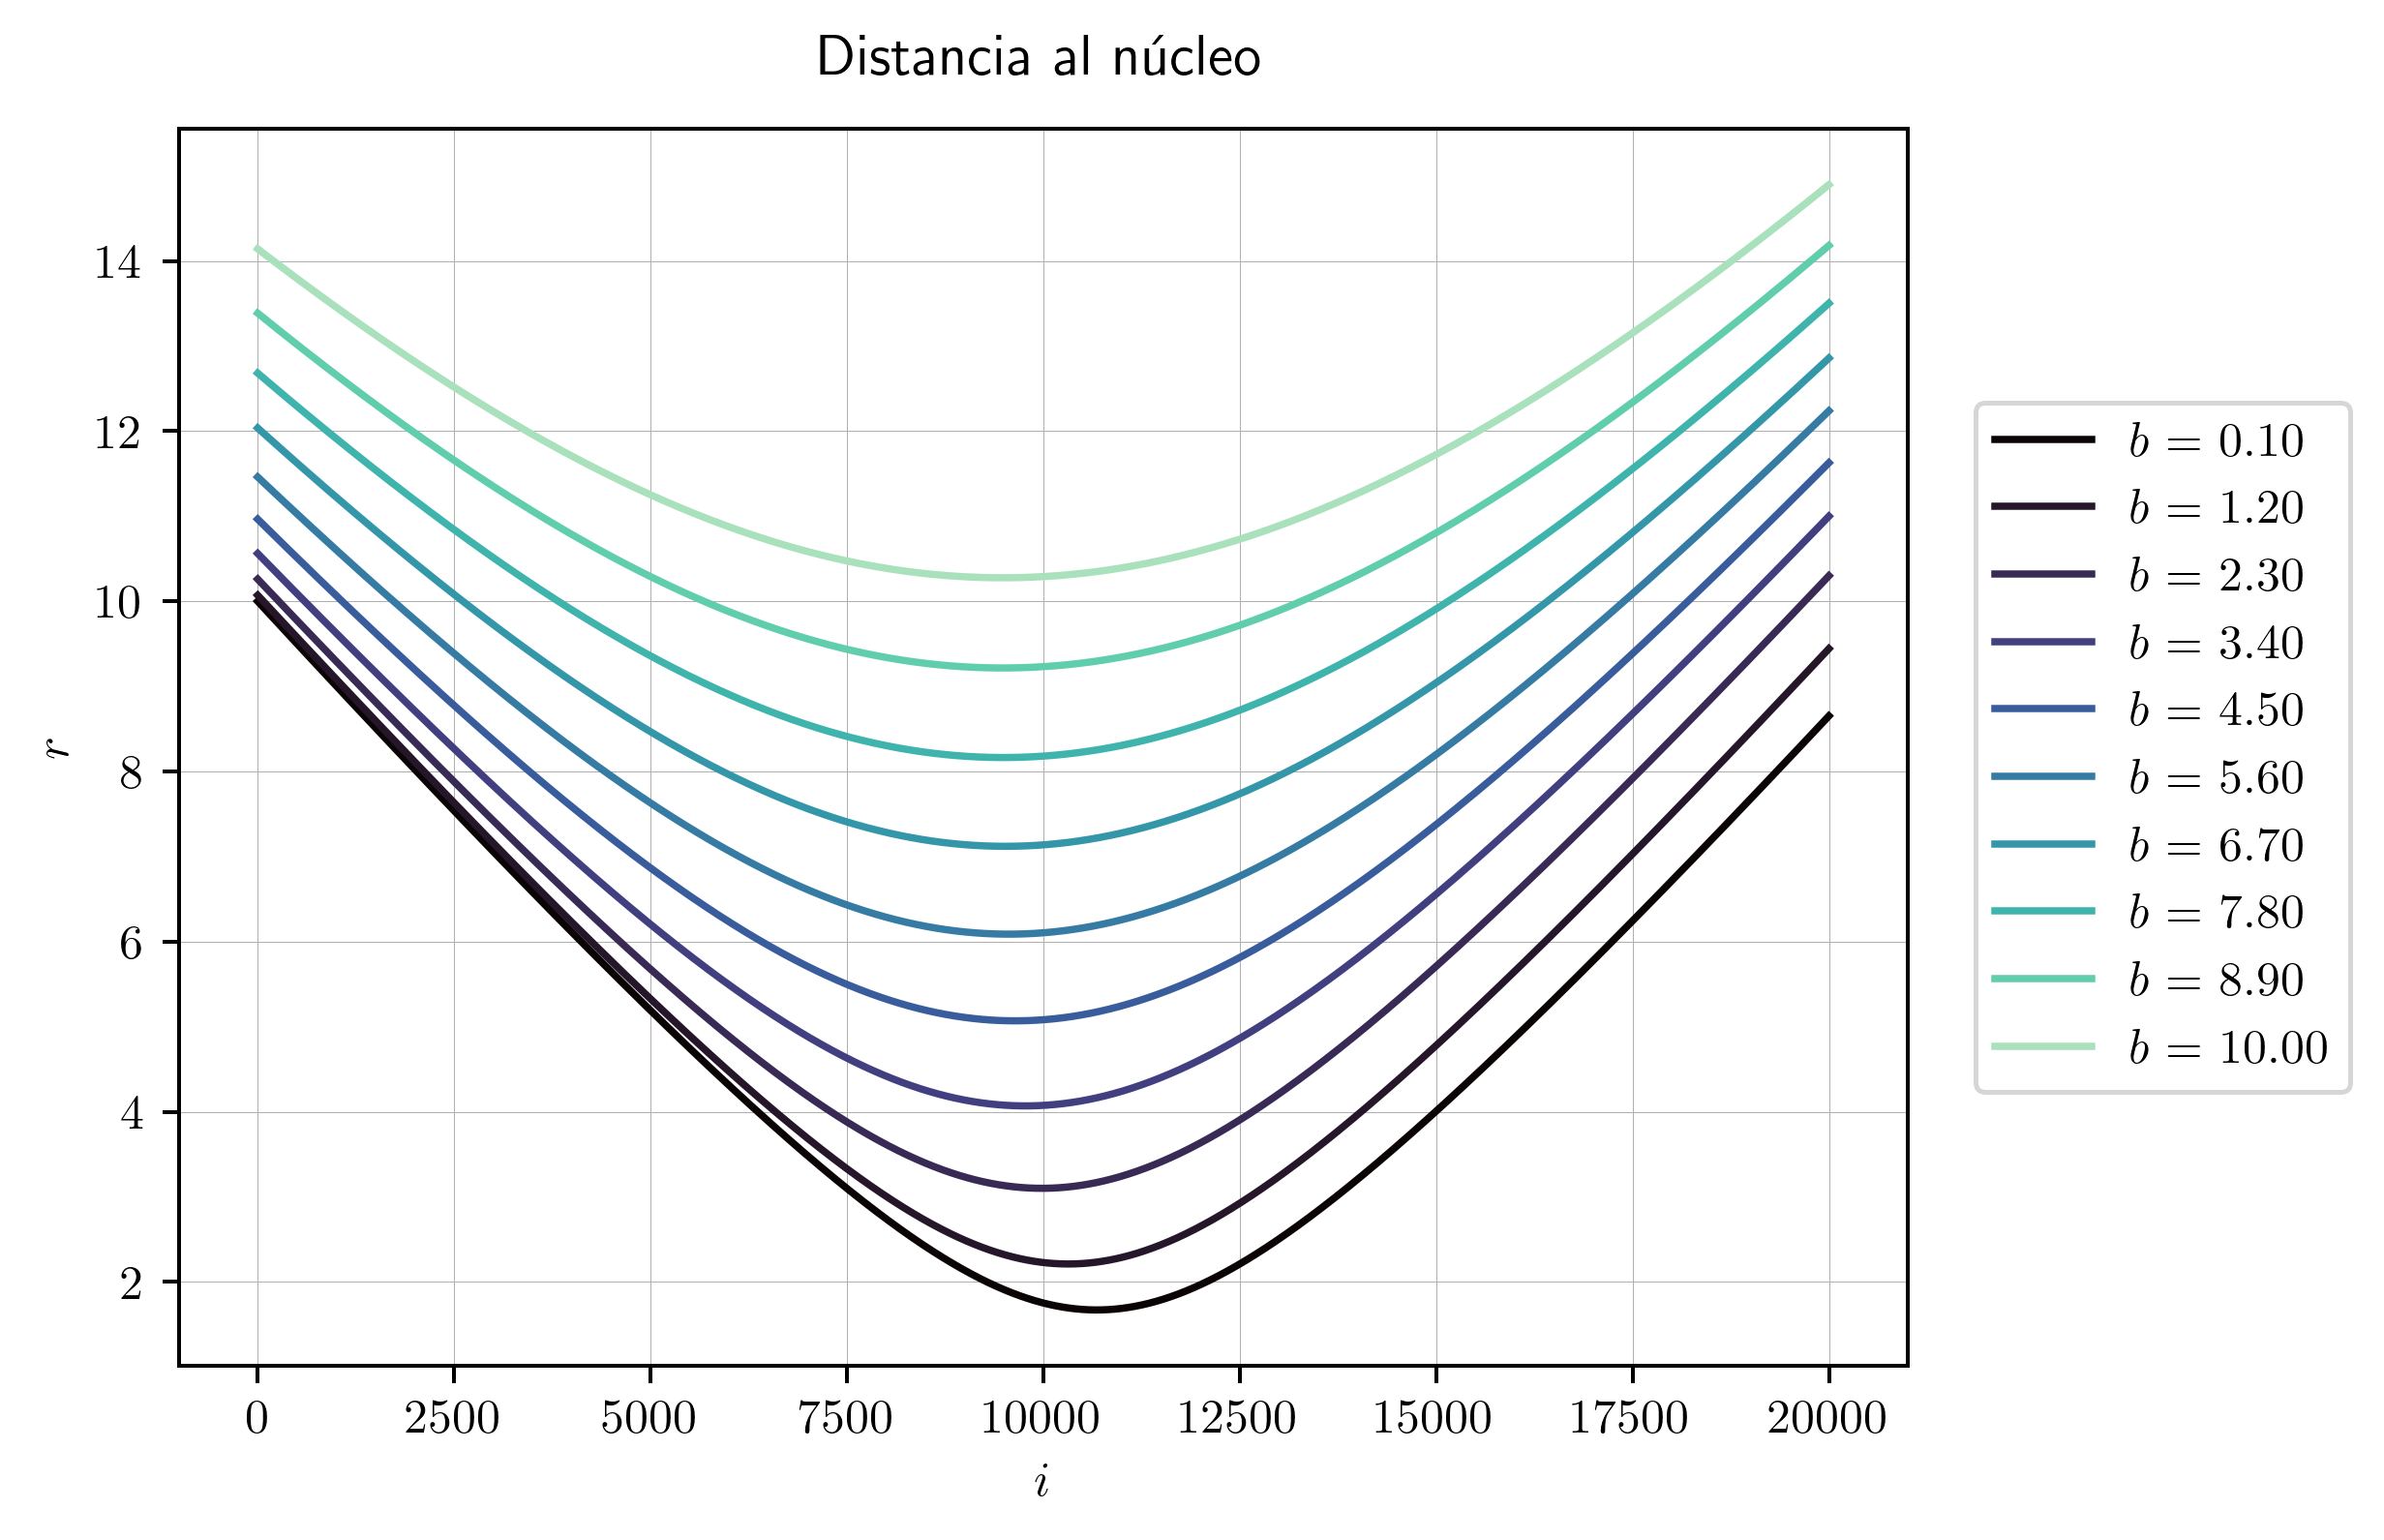

  b = 0.10: r_min = 1.6717
  b = 1.20: r_min = 2.2118
  b = 2.30: r_min = 3.1013
  b = 3.40: r_min = 4.0698
  b = 4.50: r_min = 5.0697
  b = 5.60: r_min = 6.0884
  b = 6.70: r_min = 7.1209
  b = 7.80: r_min = 8.1644
  b = 8.90: r_min = 9.2169
  b = 10.00: r_min = 10.2770


In [171]:
min_distances = plot_min_distances(trajectories_v2)
for b, r_min in min_distances.items():
    print(f"  b = {b:.2f}: r_min = {r_min:.4f}")

-----------

#### 3D scattering

In [71]:
def acceleration_3d(x, y, z, C):
    r = np.sqrt(x**2 + y**2 + z**2)
    if r == 0:
        return 0.0, 0.0, 0.0
    a_x = C * x / r**3
    a_y = C * y / r**3
    a_z = C * z / r**3
    return a_x, a_y, a_z

In [72]:
def derivatives_3d(state, C):
    x, y, z, vx, vy, vz = state
    a_x, a_y, a_z = acceleration_3d(x, y, z, C)
    return np.array([vx, vy, vz, a_x, a_y, a_z])

In [73]:
def rk4_step_3d(state, dt, C):
    k1 = derivatives_3d(state, C)
    k2 = derivatives_3d(state + 0.5 * dt * k1, C)
    k3 = derivatives_3d(state + 0.5 * dt * k2, C)
    k4 = derivatives_3d(state + dt * k3, C)
    new_state = state + dt * (k1 + 2*k2 + 2*k3 + k4) / 6.0
    return new_state

In [74]:
def simulate_trajectory_3d(b, z0, x0, v0, dt, t_final, C):
    n_steps = int(t_final / dt) + 1
    traj = np.empty((n_steps, 6))
    state = np.array([x0, b, z0, v0, 0.0, 0.0])
    traj[0] = state
    for i in range(1, n_steps):
        state = rk4_step_3d(state, dt, C)
        traj[i] = state
    return traj

In [80]:
def plot_scatter_3d(b_values):
    C, x0, v0 = 1.0, -10.0, 1.0
    dt, t_final = 0.001, 20.0
    z0 = 1.0

    cmap = sns.color_palette('mako', as_cmap=True)
    col = cmap(np.linspace(0.0, 0.9, len(b_values)))

    trajectories = {}
    for b in b_values:
        traj = simulate_trajectory_3d(b, z0, x0, v0, dt, t_final, C)
        trajectories[b] = traj

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i, (b, traj) in enumerate(trajectories.items()):
        ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], c=col[i], label=f'b = {b:.2f}')

    ax.set_xlabel('$x$'); ax.set_ylabel('$y$'); ax.set_zlabel('$z$')
    ax.set_title('Dispersión de Rutherford 3D usando RK4', y=1.02)
    ax.legend()
    ax.grid(True, linewidth=0.2)
    plt.show()

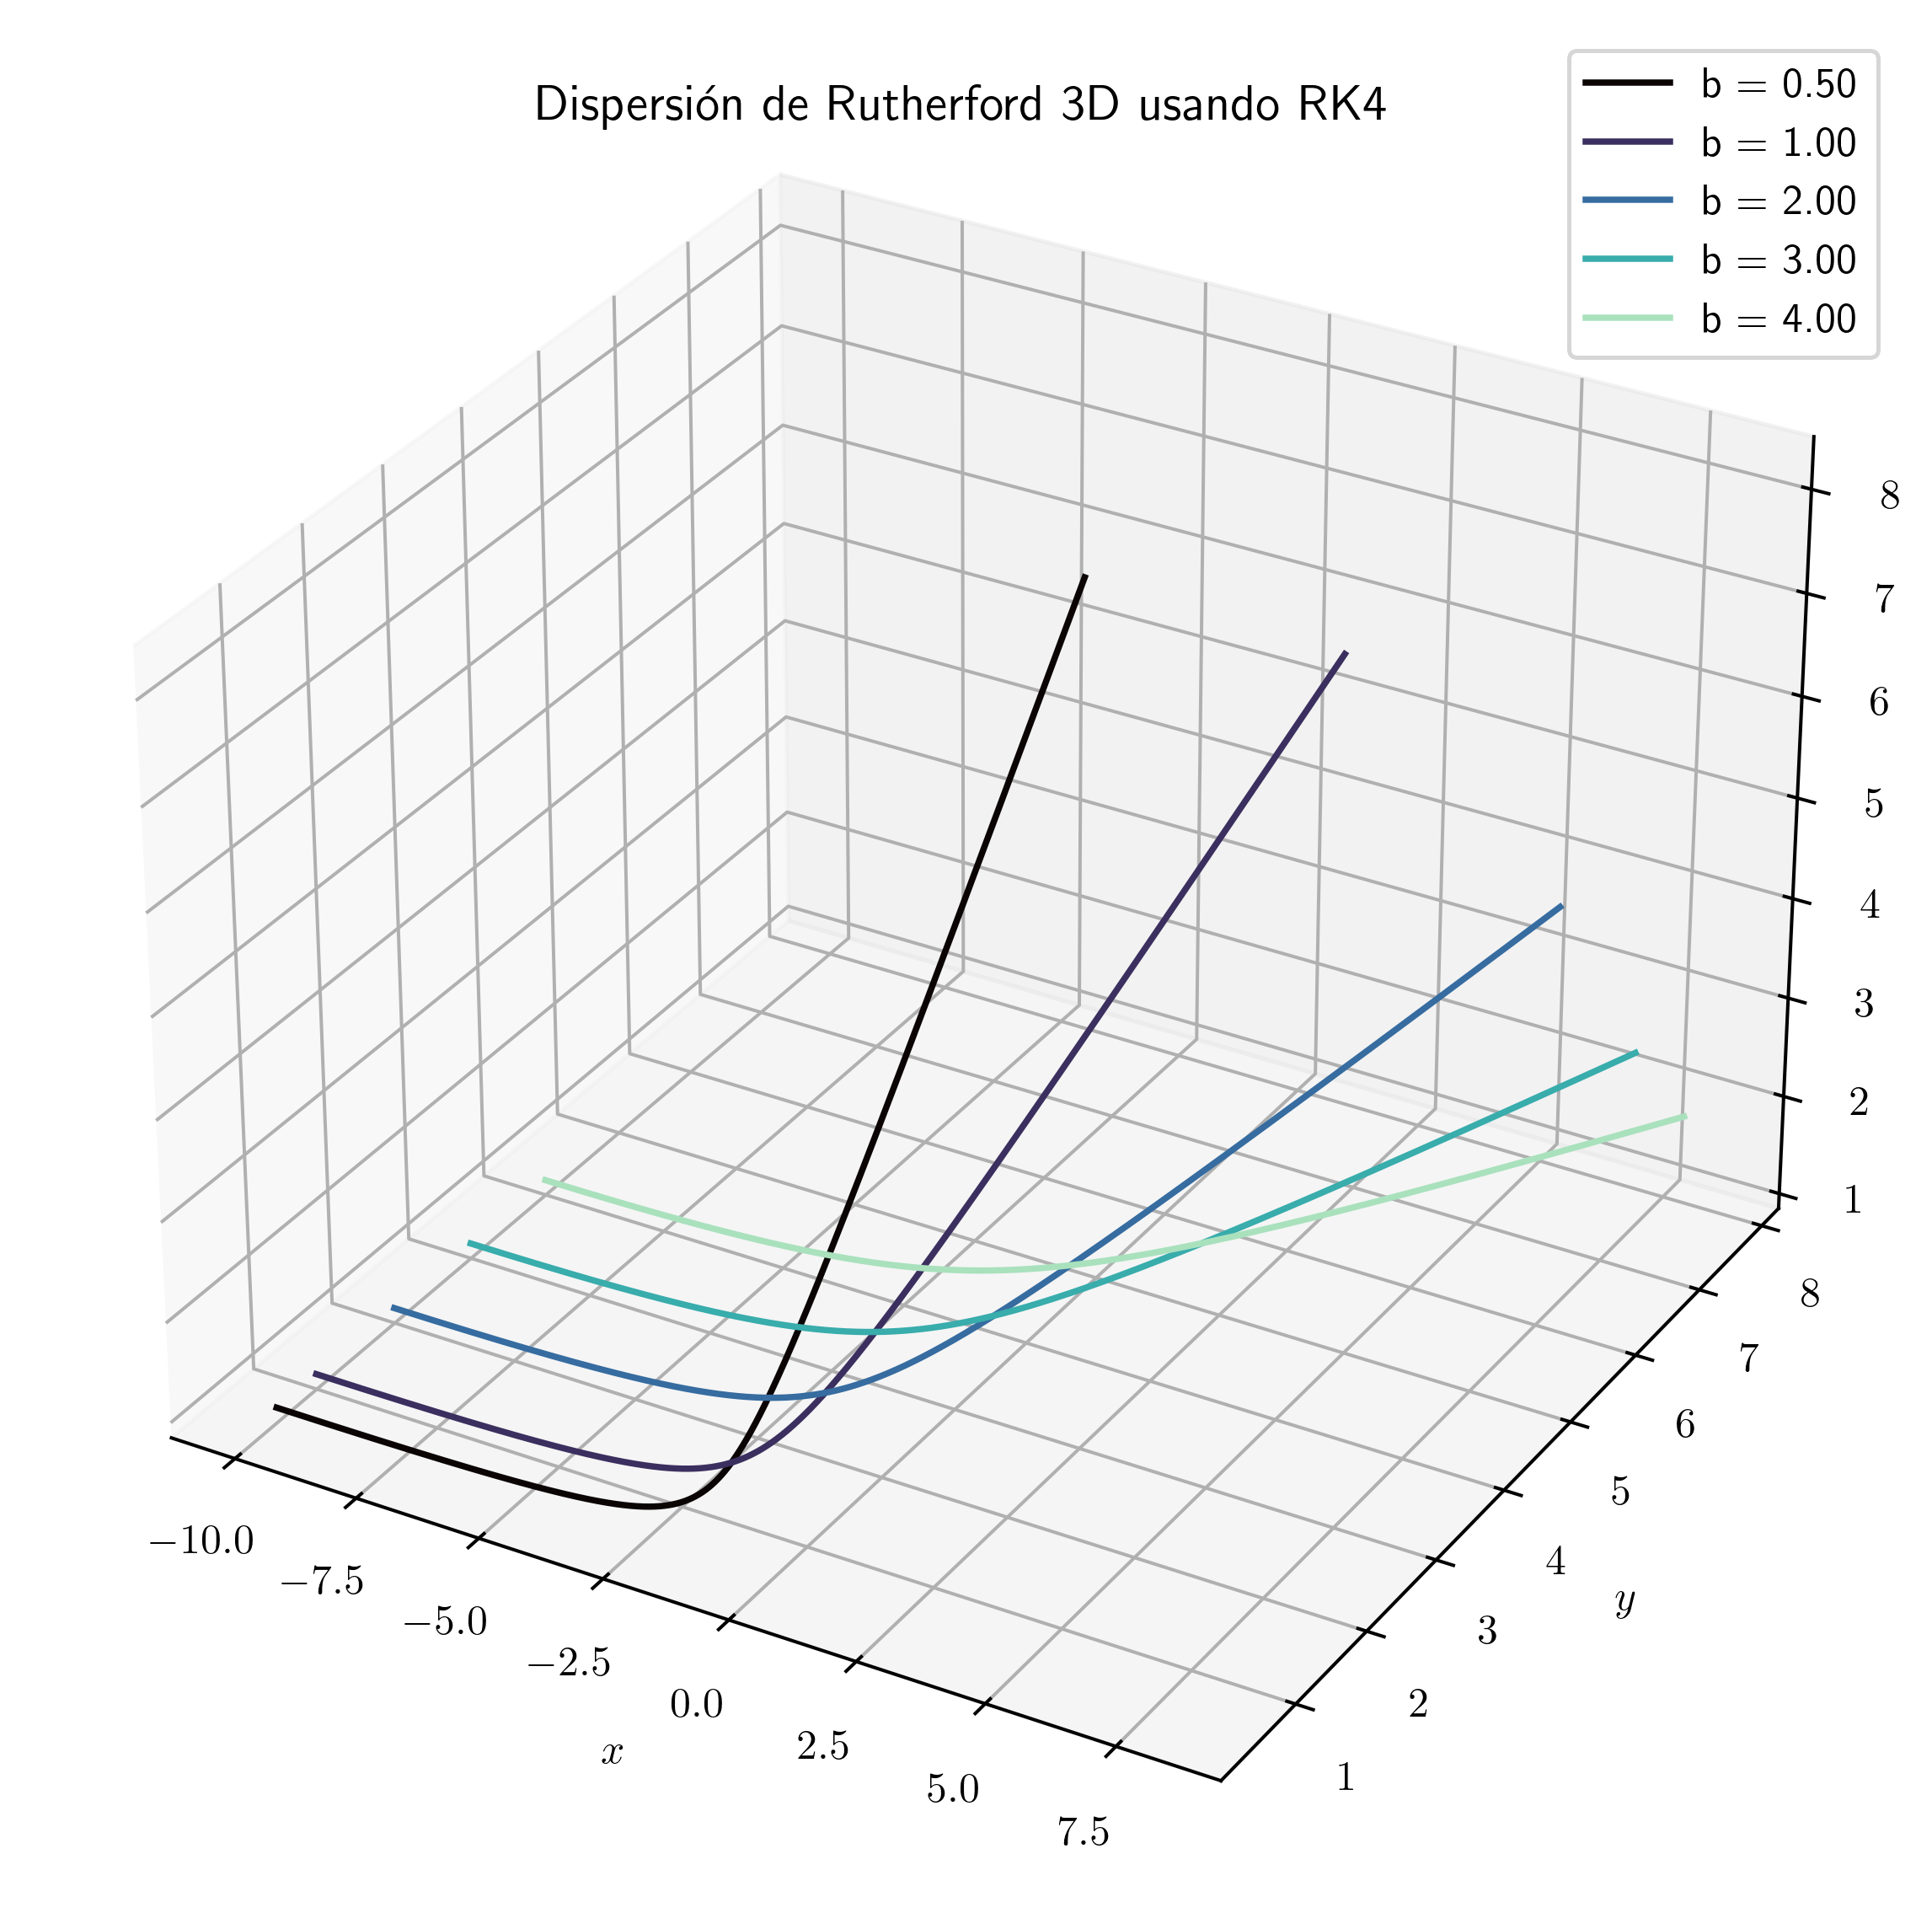

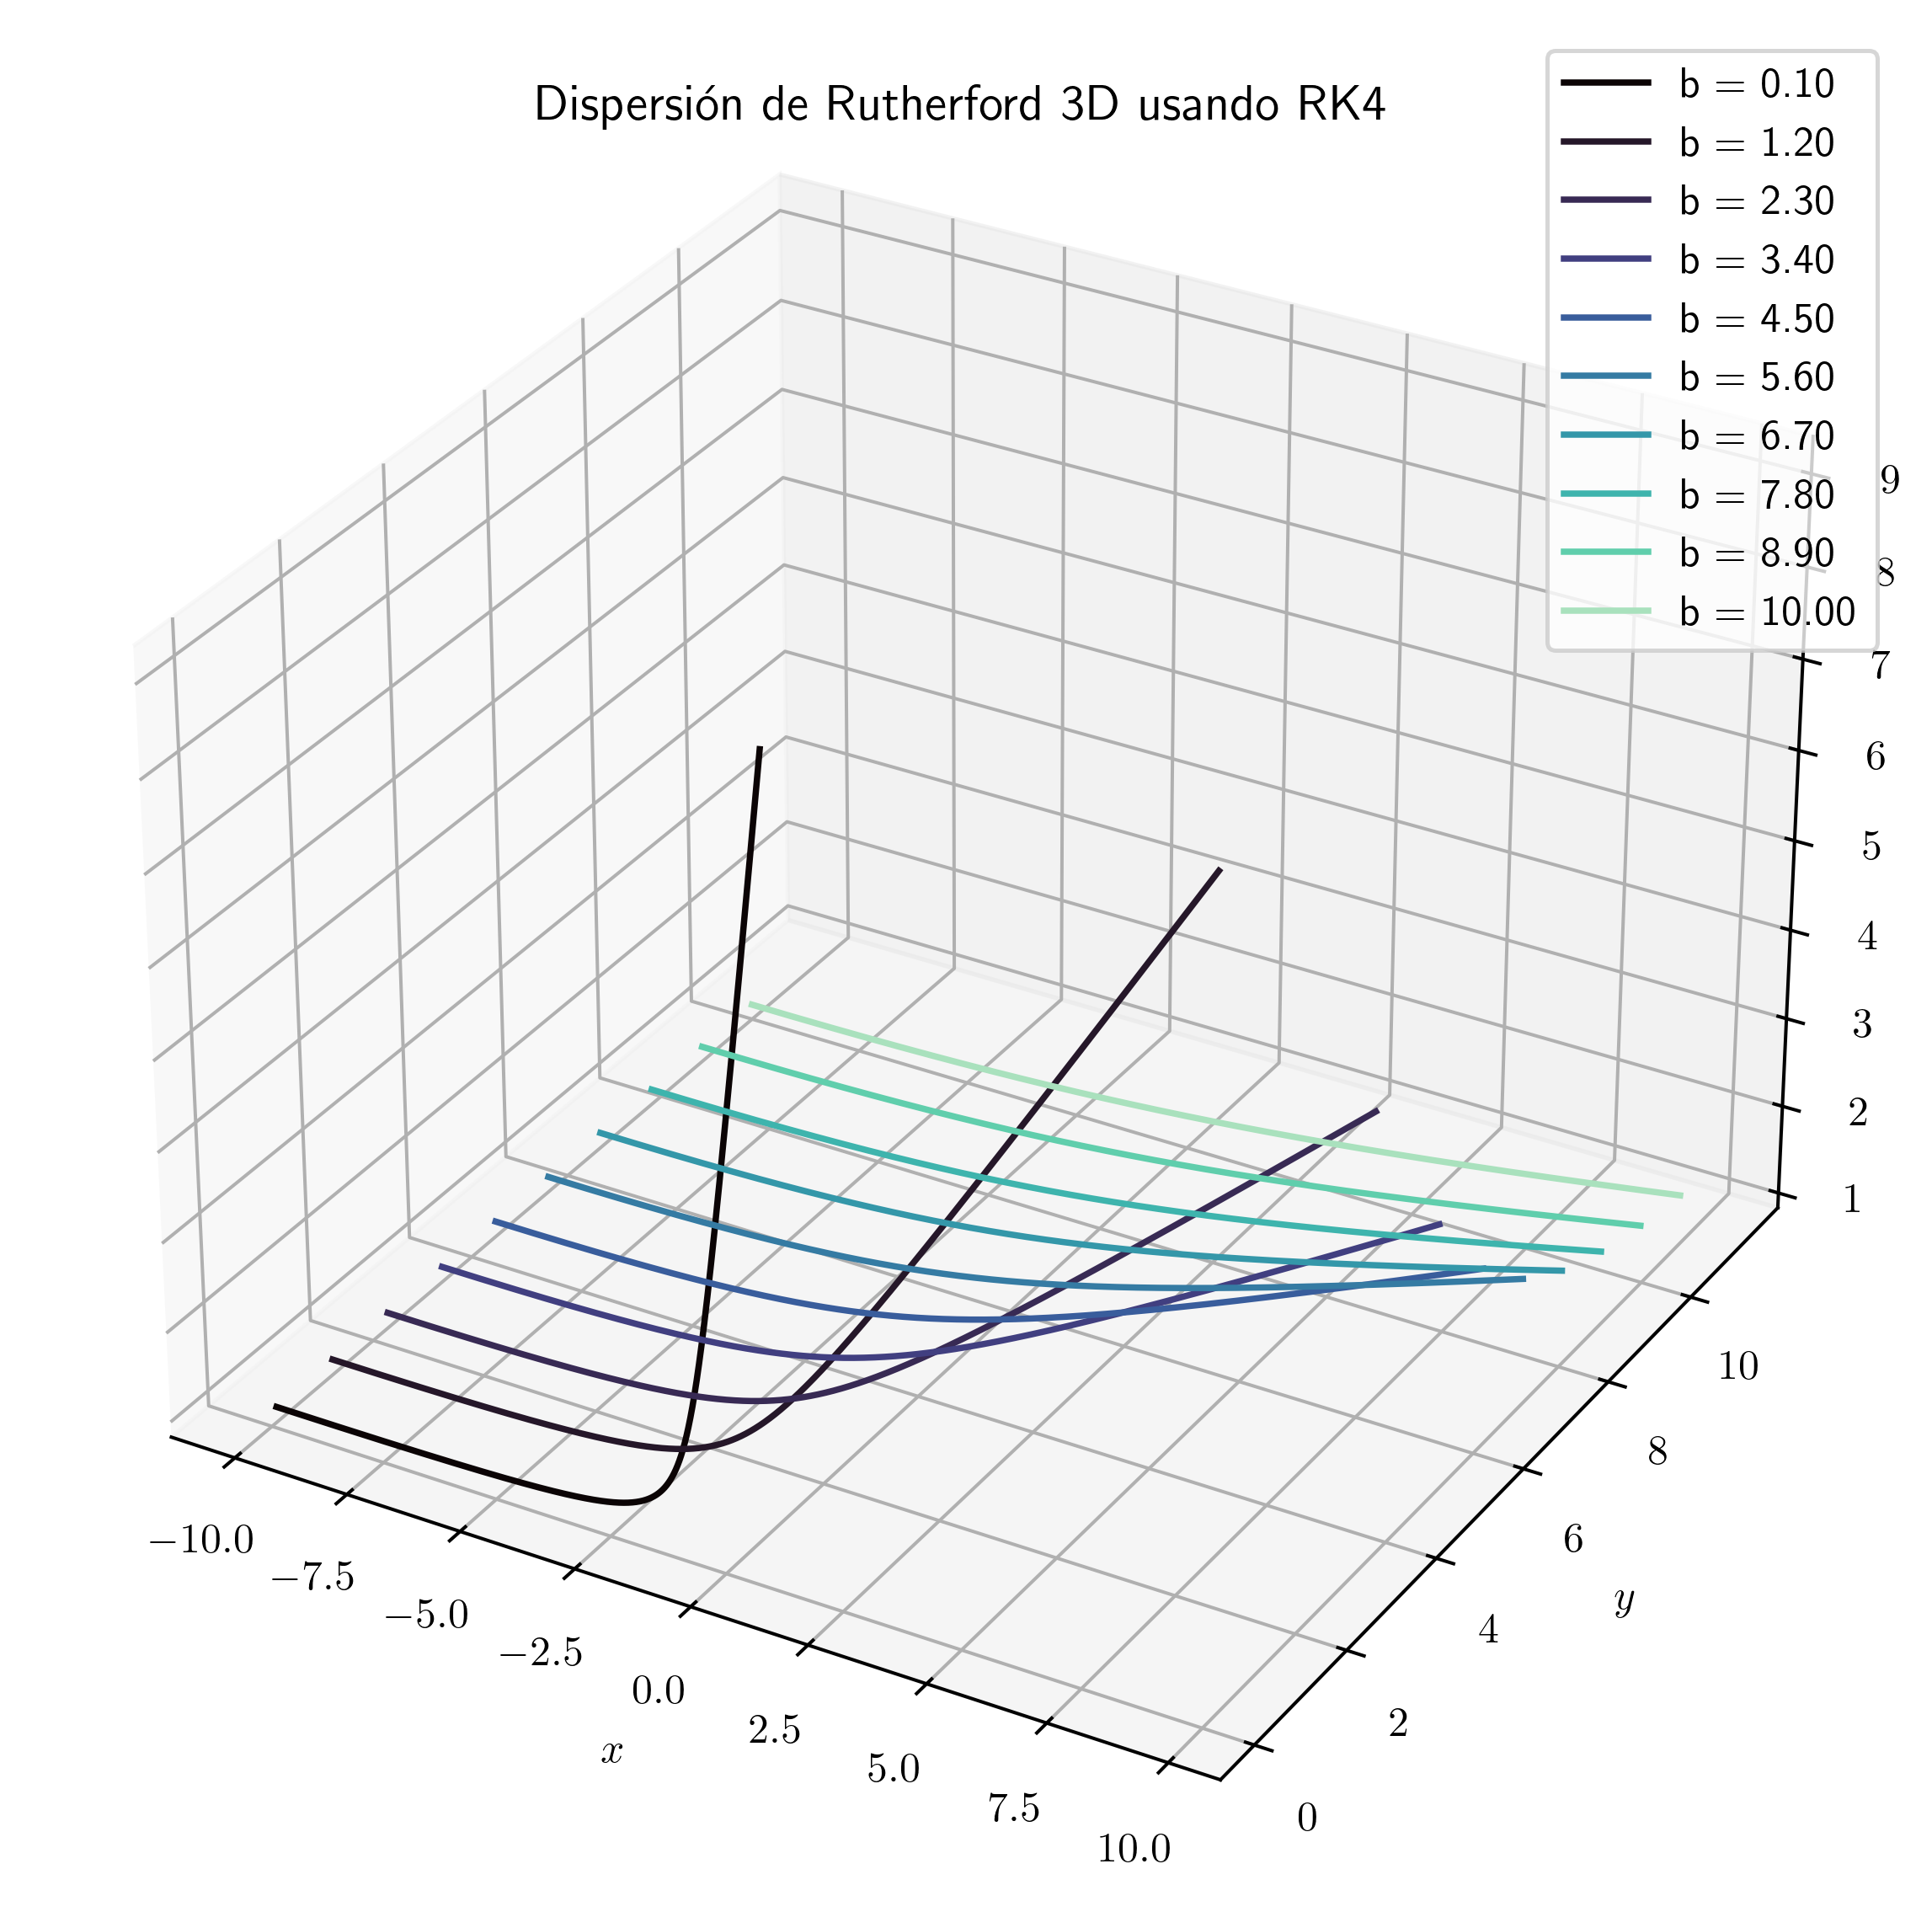

In [81]:
plot_scatter_3d([0.5, 1.0, 2.0, 3.0, 4.0])
plot_scatter_3d(np.linspace(0.1, 10, 10))